# List 3
Jan Widanka

In [15]:
import numpy as np
import matplotlib.pyplot as plt

This assignment requires an implementation of Schelling's segregation model, generally speaking mathematical model of social dynamics. The model aimed to explain how segregation in residential neighborhoods could arise even when individuals did not have a strong preference for living near others of the same race or ethnicity.

## Generating agents

We will start from generating agents on a square lattice.

In [16]:
def generate_agents_on_square_lattice(Nb, Nr, size):
    lattice = np.concatenate((-np.ones(Nb), np.ones(Nr), np.zeros(size**2 - (Nb + Nr))))
    np.random.shuffle(lattice)
    return np.array(lattice).reshape(size, size)

## Neighborhood

The function $\textit{get_non_empty_neighbors}$ takes three arguments: a 2D grid representing a matrix, a tuple representing the position for which non-empty neighbors are to be found and an integer representing the distance, specifying how far to check for neighbors in each direction. We initialize an empty list to store the non-empty $\textit{neighbors}$. Then we generate a list of tuples representing directions to check for neighbors within the specified distance ($m_{t}$) excluding the center. After that we iterate over the generated directions, calculate the new row and column by considering the periodic boundary conditions using modulo and finally we check if the value at the new position in the grid is non-zero (non-empty), and if so, add the position to the neighbors list.

In [17]:
def get_non_empty_neighbors(grid, pos, mt):
    row, col = pos
    rows, cols = len(grid), len(grid[0])
    neighbors = []

    directions = [(i, j) for i in range(-mt, mt + 1) for j in range(-mt, mt + 1) if i != 0 or j != 0]

    for i, j in directions:
        new_row = (row + i) % rows
        new_col = (col + j) % cols

        if grid[new_row][new_col] != 0:
            neighbors.append((new_row, new_col))

    return neighbors

## Similar neighbor index

Function $\textit{calculate_similar_index}$ computes a similarity index for a given position in the grid based on its neighbors. Here we create, so called $\textit{statuses}$ containing the values of the grid at the positions of the neighbors and count the occurrences of the $\textit{same_type}$ and the opposite type ($\textit{other_type}$) in the $\textit{statuses}$ array. Finally we use the formula for our segregation index in the following way: 

$$\begin{equation}
\frac{\text{same type}}{\text{same type + other type}},
\end{equation}$$

with a check to avoid division by zero.

In [18]:
def calculate_similar_index(grid, pos, mt):    
    neighbors = get_non_empty_neighbors(grid, pos, mt)
    statuses = np.array([grid[i] for i in neighbors])
    agent_type = grid[pos[0], pos[1]]
    same_type = len(np.argwhere(statuses == agent_type))
    other_type = len(np.argwhere(statuses == -agent_type))
    
    sn_index = same_type / (same_type + other_type) if (same_type + other_type) > 0 else 0
    return sn_index

The second function $\textit{get_similar_neighbor_indices}$ applies the previous calculation to all non-empty positions in the grid, returning an array of similarity indices.

In [19]:
def get_similar_neighbor_indices(grid, mt):
    none_empty_positions = np.argwhere(grid != 0)
    return np.array([calculate_similar_index(grid, agent, mt) for agent in none_empty_positions])

## Simulation

The function $\textit{one_step}$ performs one step of the Schelling segregation model. It iterates through each agent in a shuffled order. If the calculated similarity index for an agent is less than the threshold $j_{t}$, it finds a random empty cell and moves the agent to that cell. The function returns the updated grid after one step.

In [20]:
def one_step(grid, mt, jt):
    agents = np.argwhere(grid != 0)
    np.random.shuffle(agents)
    for agent in agents:
        if calculate_similar_index(grid, agent, mt) < jt:
            agent_state = grid[agent[0], agent[1]]
            new_agent_position = np.argwhere(grid == 0)[np.random.choice(np.count_nonzero(grid == 0), size = 1)[0]]
            grid[new_agent_position[0], new_agent_position[1]] = agent_state
            grid[agent[0], agent[1]] = 0
    return grid

Second function $\textit{all_states}$ simulates the Schelling model until all agents are satisfied with their neighborhoods.
It initializes the simulation with a randomly generated initial state. It iteratively calls the $\textit{one_step}$ function until the similarity index for all agents is greater than or equal to the threshold $j_{t}$. It returns a list of states during the simulation and the number of cycles it took to reach the final state.

In [21]:
def all_states(Nr, Nb, size, mt, jt):
    states_list = [generate_agents_on_square_lattice(Nr, Nb, size)]
    cycles = 0

    while not np.all(get_similar_neighbor_indices(states_list[-1], mt) >= jt):
        states_list.append(one_step(states_list[-1].copy(), mt, jt))
        cycles += 1

    return states_list, cycles

Finally $\textit{final_state}$ returns the final state and the number of cycles it took to reach that exact state. It initializes the simulation with a randomly generated initial state. It iteratively calls the $\textit{one_step}$ function until the similarity index for all agents is greater than or equal to the threshold $j_{t}$ and returns the final state and the number of cycles.

In [22]:
def final_state(Nr, Nb, size, mt, jt):
    grid = generate_agents_on_square_lattice(Nr, Nb, size)
    cycles = 0

    while not np.all(get_similar_neighbor_indices(grid, mt) >= jt):
        grid = one_step(grid, mt, jt)
        cycles += 1

    return grid, cycles

## Baseline model

We set the parameters of our initial model and then we plot the result.

In [49]:
size = 100
Nb_vals = [250, 3000]
Nr_vals = [250, 3000]
mt = 1
jt = 0.5

initial_grid_250 = generate_agents_on_square_lattice(Nb_vals[0], Nr_vals[0], size)
initial_grid_3000 = generate_agents_on_square_lattice(Nb_vals[1], Nr_vals[1], size)
perf_st = one_step(initial_grid, mt, jt)
result = all_states(Nr, Nb, size, mt, jt)

### Initial distribution

Here we have the initial distribution of the agents.

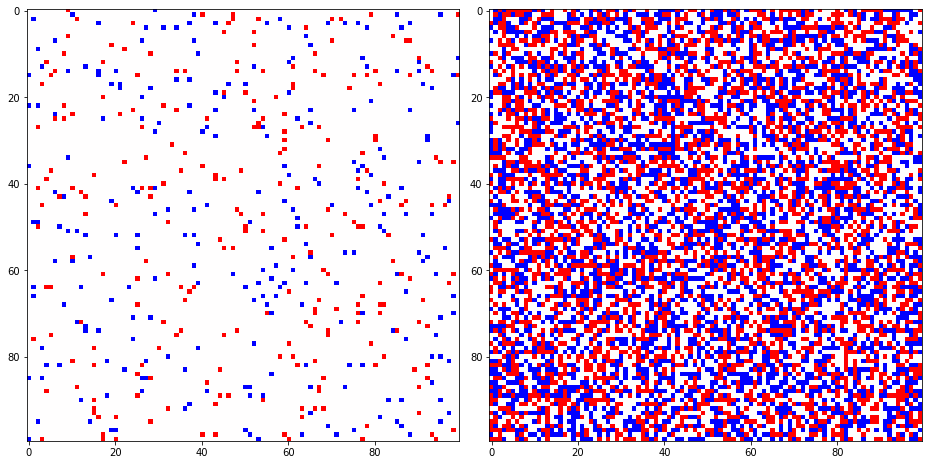

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(13,8))

ax[0].imshow(initial_grid_250, cmap='bwr', interpolation='none', origin='upper')
ax[1].imshow(initial_grid_3000, cmap='bwr', interpolation='none', origin='upper')
plt.tight_layout()
plt.show()

### Final distribution

Here we plot the final distribution.

In [54]:
final_distr_250 = final_state(Nb_vals[0], Nr_vals[0], size, mt, jt)[0]
final_distr_3000 = final_state(Nb_vals[1], Nr_vals[1], size, mt, jt)[0]

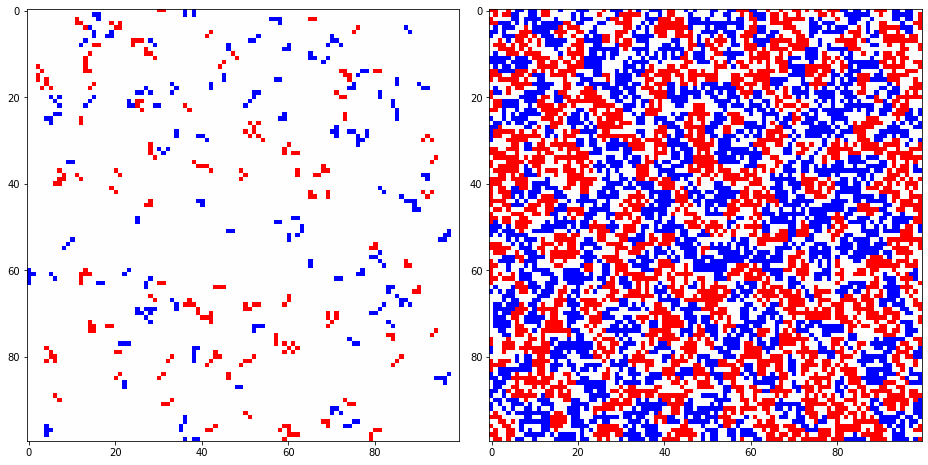

In [55]:
fig, ax = plt.subplots(1, 2, figsize=(13,8))

ax[0].imshow(final_distr_250, cmap='bwr', interpolation='none', origin='upper')
ax[1].imshow(final_distr_3000, cmap='bwr', interpolation='none', origin='upper')
plt.tight_layout()
plt.show()

### Distributions on one plot

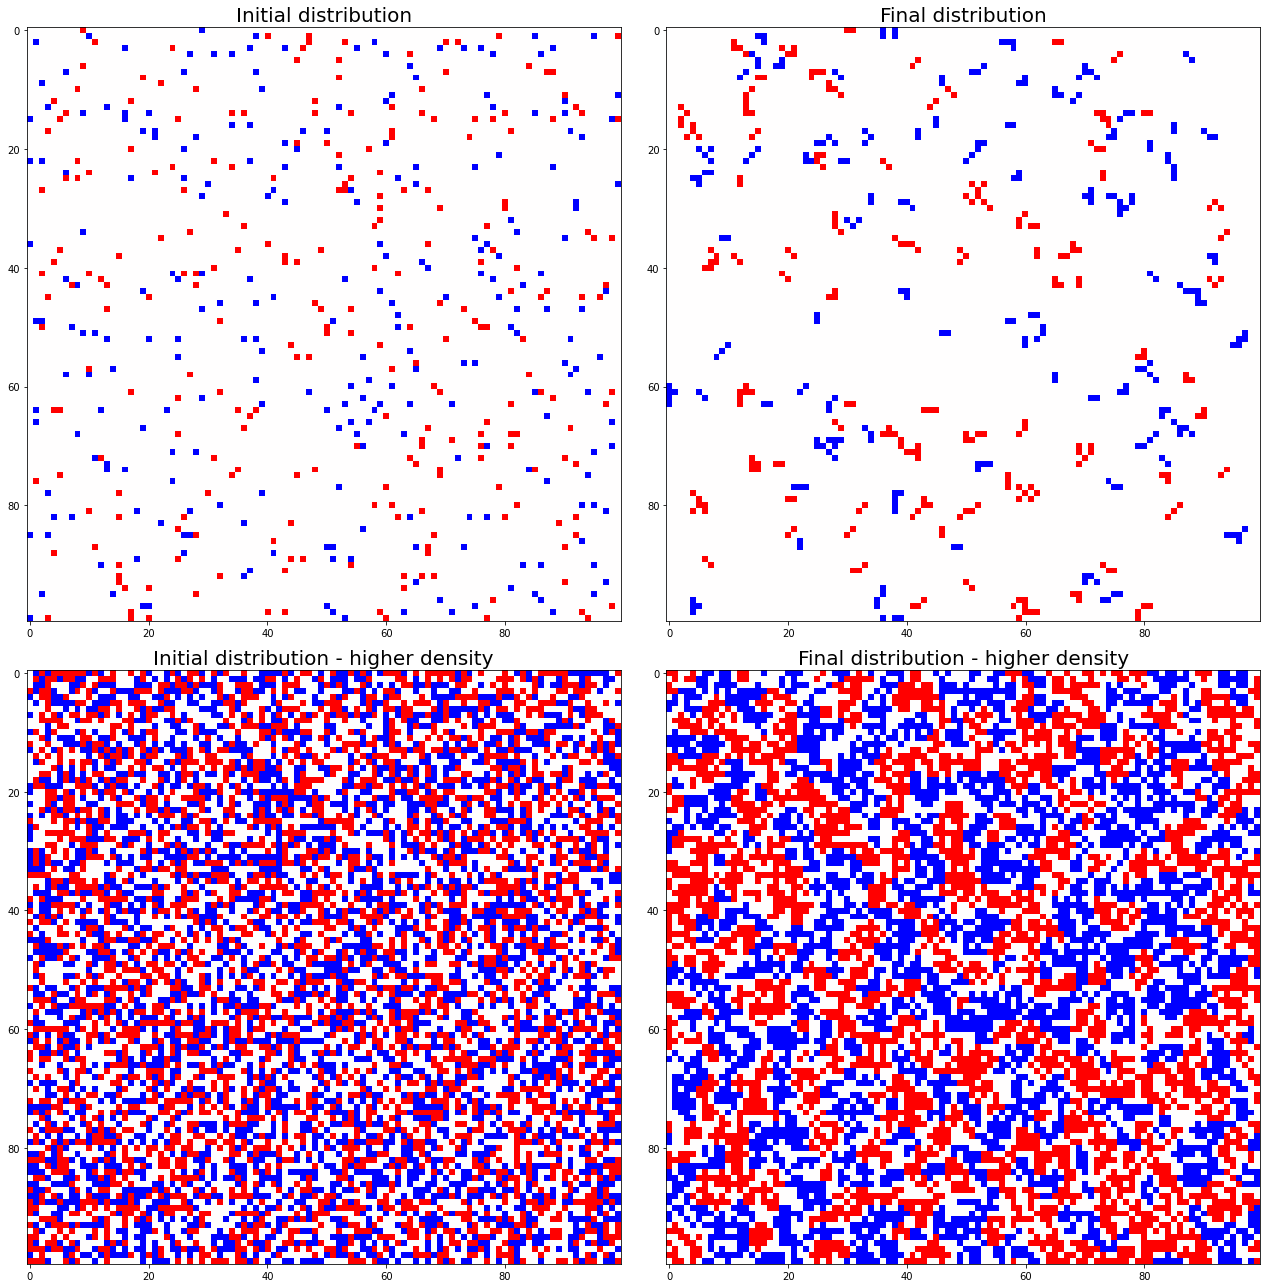

In [68]:
fig, ax = plt.subplots(2, 2, figsize=(18,18))

ax[0,0].imshow(initial_grid_250, cmap='bwr', interpolation='none', origin='upper')
ax[0,0].set_title('Initial distribution', fontsize = 20)
ax[0,1].imshow(final_distr_250, cmap='bwr', interpolation='none', origin='upper')
ax[0,1].set_title('Final distribution', fontsize = 20)
ax[1,0].imshow(initial_grid_3000, cmap='bwr', interpolation='none', origin='upper')
ax[1,0].set_title('Initial distribution - higher density', fontsize = 20)
ax[1,1].imshow(final_distr_3000, cmap='bwr', interpolation='none', origin='upper')
ax[1,1].set_title('Final distribution - higher density', fontsize = 20)
plt.tight_layout()
plt.show()

## Number of iterations as a function of population size

Let us concentrate on the next task. Here we are going to obtain a plot contating number of iterations and different population sizes. We start from setting the parameters and choosing the population sizes from $250$ to $4000$ with a step size of $250$. Then we perform simulation for each population size, running the $\textit{final_state}$ function. We do it multiple times ($100$ times in this case) and collect the number of iterations for each run.

In [167]:
size = 100
mt = 1
reps = 100
jt = 0.5

population_sizes = np.arange(250, 4001, 250)
iterations = np.zeros(len(population_sizes))

for i in range(len(population_sizes)):
    iterations[i] = np.mean([final_state(population_sizes[i], population_sizes[i], size, mt, jt)[1] for _ in range(reps)])
    
#np.savetxt(f"number_of_iterations.txt", iterations)

In [163]:
result_number_of_iter = np.loadtxt('number_of_iterations.txt')

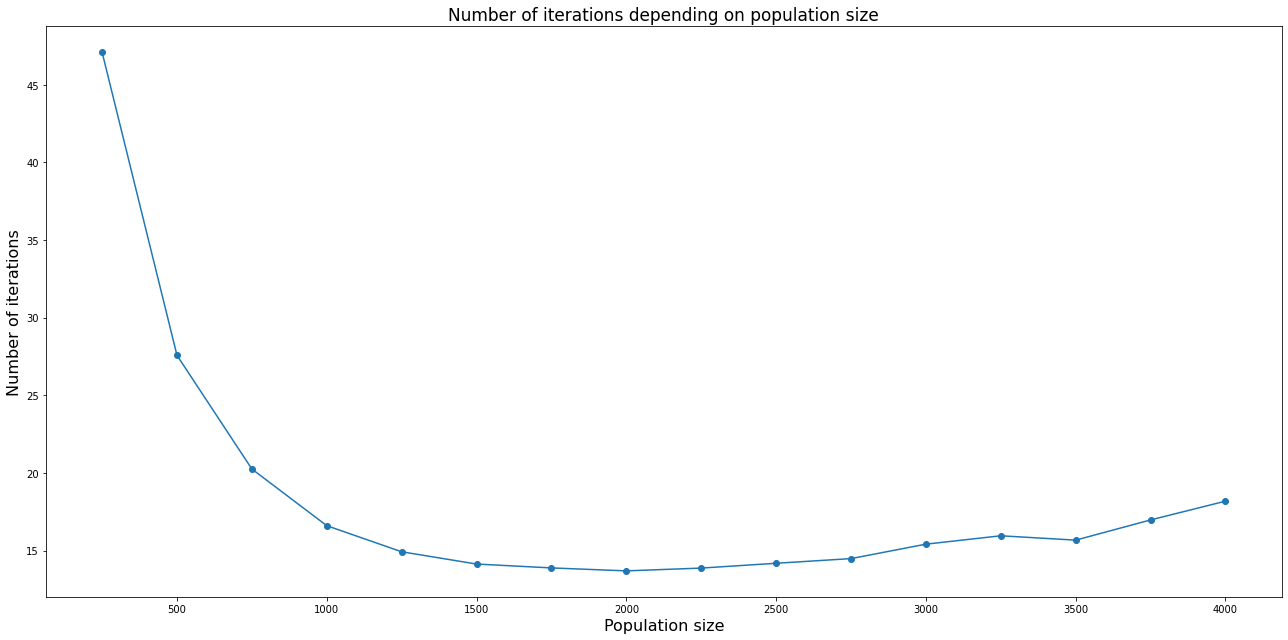

In [182]:
plt.figure(figsize = (18, 9))
plt.plot(population_sizes, result_number_of_iter, marker='o')
plt.title('Number of iterations depending on population size', fontsize = 17)
plt.xlabel('Population size', fontsize = 16)
plt.ylabel('Number of iterations', fontsize = 16)
plt.tight_layout()
plt.show()

A decrease in the number of iterations as the population size increases could indicate that the algorithm becomes more efficient with larger populations. It suggests that the system stabilizes more quickly as the number of interacting agents grows. The decrease in iterations might also be influenced by the sensitivity of the algorithm to the parameters $m_t$ and $j_t$.

## Segregation index as a function of $j_{t}$

In this task we are going to plot a relation between segregation index and similarity threshold $j_t$. We start from systematically varying the similarity threshold values from $0.1$ to $0.8$ in this case. Then we run simulations for each $j_t$ and calculate segregation indices. After that we concentrate on averaging the indices for each value of similarity threshold. The final result is an array ($\textit{final_segregation_indices_j_t}$) containing the mean segregation indices for different values of $j_t$.

In [175]:
jt_values = np.linspace(0.1, 0.8, 8)
size = 100
population = 1000
mt = 1


final_segregation_indices_j_t = np.zeros(len(jt_values))

for i in range(len(jt_values)):
    final_segregation_indices_j_t[i] = np.mean(get_similar_neighbor_indices(final_state(population, population, size, mt, jt_values[i])[0], mt))


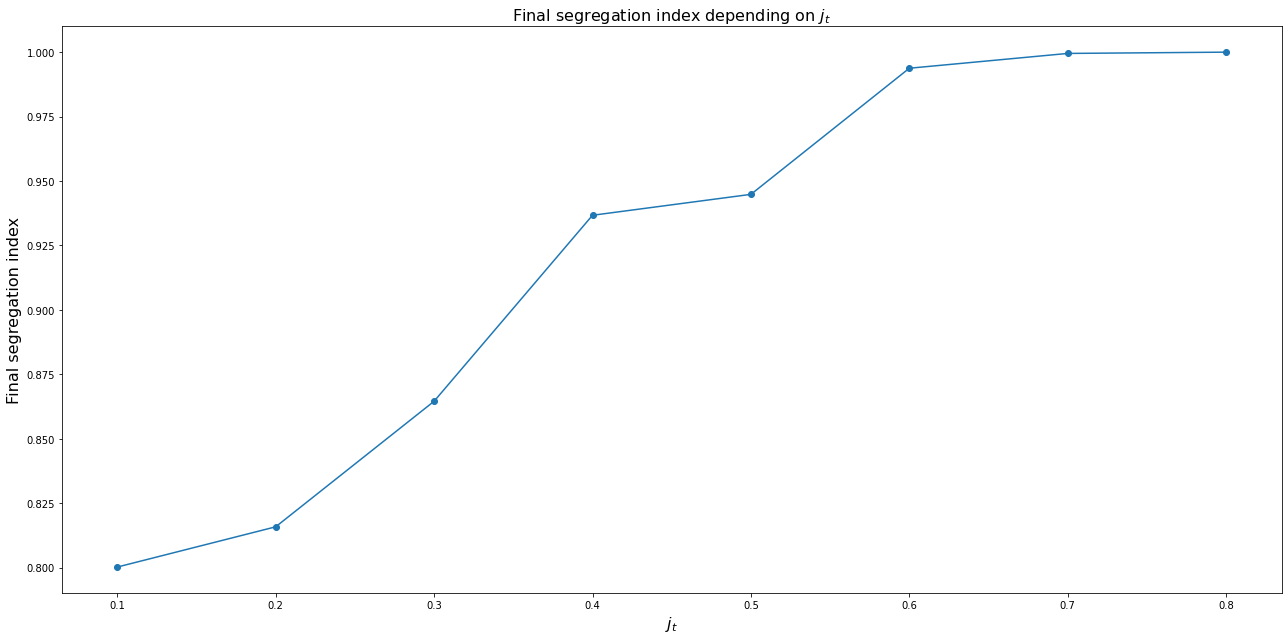

In [183]:
plt.figure(figsize = (18, 9))
plt.plot(jt_values, final_segregation_indices_j_t, marker='o')
plt.title('Final segregation index depending on $j_{t}$', fontsize = 16)
plt.xlabel('$j_{t}$', fontsize = 16)
plt.ylabel('Final segregation index', fontsize = 16)
plt.tight_layout()
plt.show()

The plot allows us to observe how changing the threshold $j_{t}$ affects the final segregation indices. Generally we observe that as the similarity threshold ($j_t$) increases, the segregation index also increases. This is because agents become more selective in their neighborhood, requiring a higher proportion of similar neighbors before they are satisfied. At point $j_t = 0.3$ we can see the sharpest increase in the final segregation index.

## Segregation index as a function of $m_{t}$

Now we will concentrate on segregation index as a function of $m_t$. Here we are taking the specified $m_t$ values, running multiple simulations for each value, calculating segregation indices for each repetition, and then averaging the indices. The final result $\textit{final_segregation_indices}$ contains the mean segregation indices. For each $m_t$ value, a simulation is performed using the $\textit{final_state}$ function. The resulting final state is passed to the $\textit{get_similar_neighbor_indices}$ function, which likely calculates the segregation index based on the similarity of neighbors. The calculated segregation indices for each repetition are stored in the $\textit{final_segregation_indices}$ array. For this task we use the population equal to 2000.

In [9]:
mt_values = np.arange(1, 6, 1)
population = 2000
reps = 100
size = 100
jt = 0.5

final_segregation_indices = np.zeros(len(mt_values))

for i in range(len(mt_values)):
    for _ in range(reps):
        final_segregation_indices[i] = np.mean(get_similar_neighbor_indices(final_state(population, population, size, mt_values[i], jt)[0], mt_values[i]))

In [143]:
segregation_index_m_t = np.savetxt(f"seg_index_dep_m_t.txt", final_segregation_indices)

In [16]:
segregation_index_m_t_result = np.loadtxt('seg_index_dep_m_t.txt')

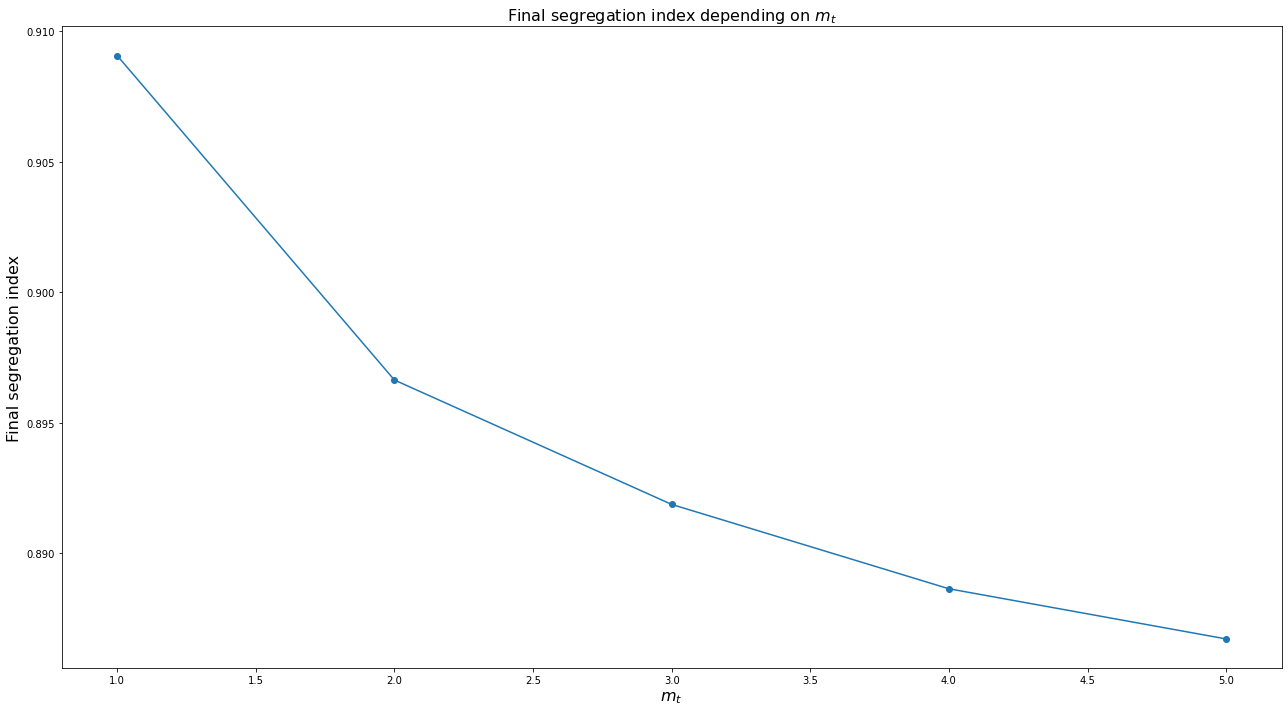

In [17]:
mt_values = np.arange(1, 6, 1)

plt.figure(figsize = (18, 10))
plt.plot(mt_values, segregation_index_m_t_result, marker='o')
plt.title('Final segregation index depending on $m_{t}$', fontsize = 16)
plt.xlabel('$m_{t}$', fontsize = 16)
plt.ylabel('Final segregation index', fontsize = 16)
plt.tight_layout()
plt.show()

From the plot we can observe that by increasing the $m_t$ parameter we obtain a decrease in final segregation index. The more closest neighbors we consider the smaller similar neighbor index we obtain. At the end we can see that the values are more and more stabilized.